In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [50]:
import torch
from permacache import stable_hash

import frame_alignment_checks as fac
from matplotlib import pyplot as plt

from render_psam import render_psams

from orthogonal_dfa.data.exon import default_exon
from orthogonal_dfa.manual_dfa.splice_site_dfa import splice_site_psam_pdfa
from orthogonal_dfa.psams.psam_pdfa import PSAMPDFA, PSAMPDFAWithTemperature
from orthogonal_dfa.psams.train import (
    identify_first_best_by_validation,
    train_psam_pdfa_full_learning_curve,
)
from orthogonal_dfa.spliceai.load_model import load_spliceai
from orthogonal_dfa.oracle.run_model import create_dataset
from orthogonal_dfa.experiments.train_from_scratch import *

In [4]:
oracle = load_spliceai(400, 0).cuda()
random, hard_target = create_dataset(
    default_exon,
    oracle,
    count=10_000,
    seed=0,
)

In [5]:
import numpy as np

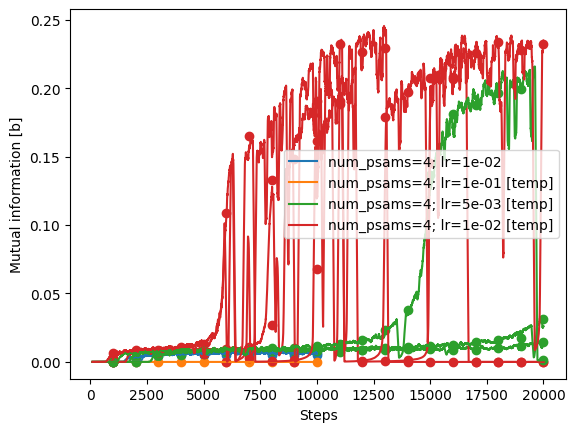

In [6]:
pdfa_res = plots_for_pdfa()
plt.legend()
plt.ylabel("Mutual information [b]")
plt.xlabel("Steps")
plt.show()

Parameter containing:
tensor(-0.0028, requires_grad=True)


array([<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>,
       <Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>],
      dtype=object)

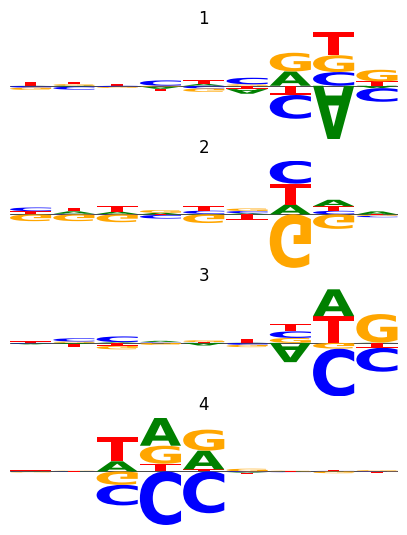

In [7]:
m = train_model(0, 4, 1e-2, with_temperature=1, epochs=200)[0][-1]
print(m.temperature)
m = m.psam_pdfa
p = m.psam
render_psams(
    p.sequence_logos, names=range(1, 1 + len(p.sequence_logos)), psam_mode="raw"
)

0 0.50201225 4@50%
2 0.20866421 4@21%
3 0.23394436 4@23%


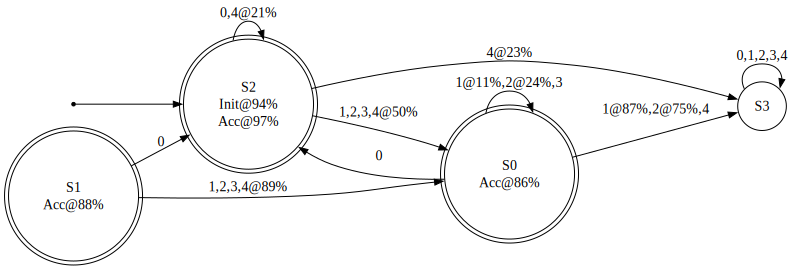

In [8]:
m.pdfa.to_dfa_for_viz(0.1)

In [9]:
from orthogonal_dfa.baseline import MonolithicLinearLayer, PSAMsFollowedByLinear

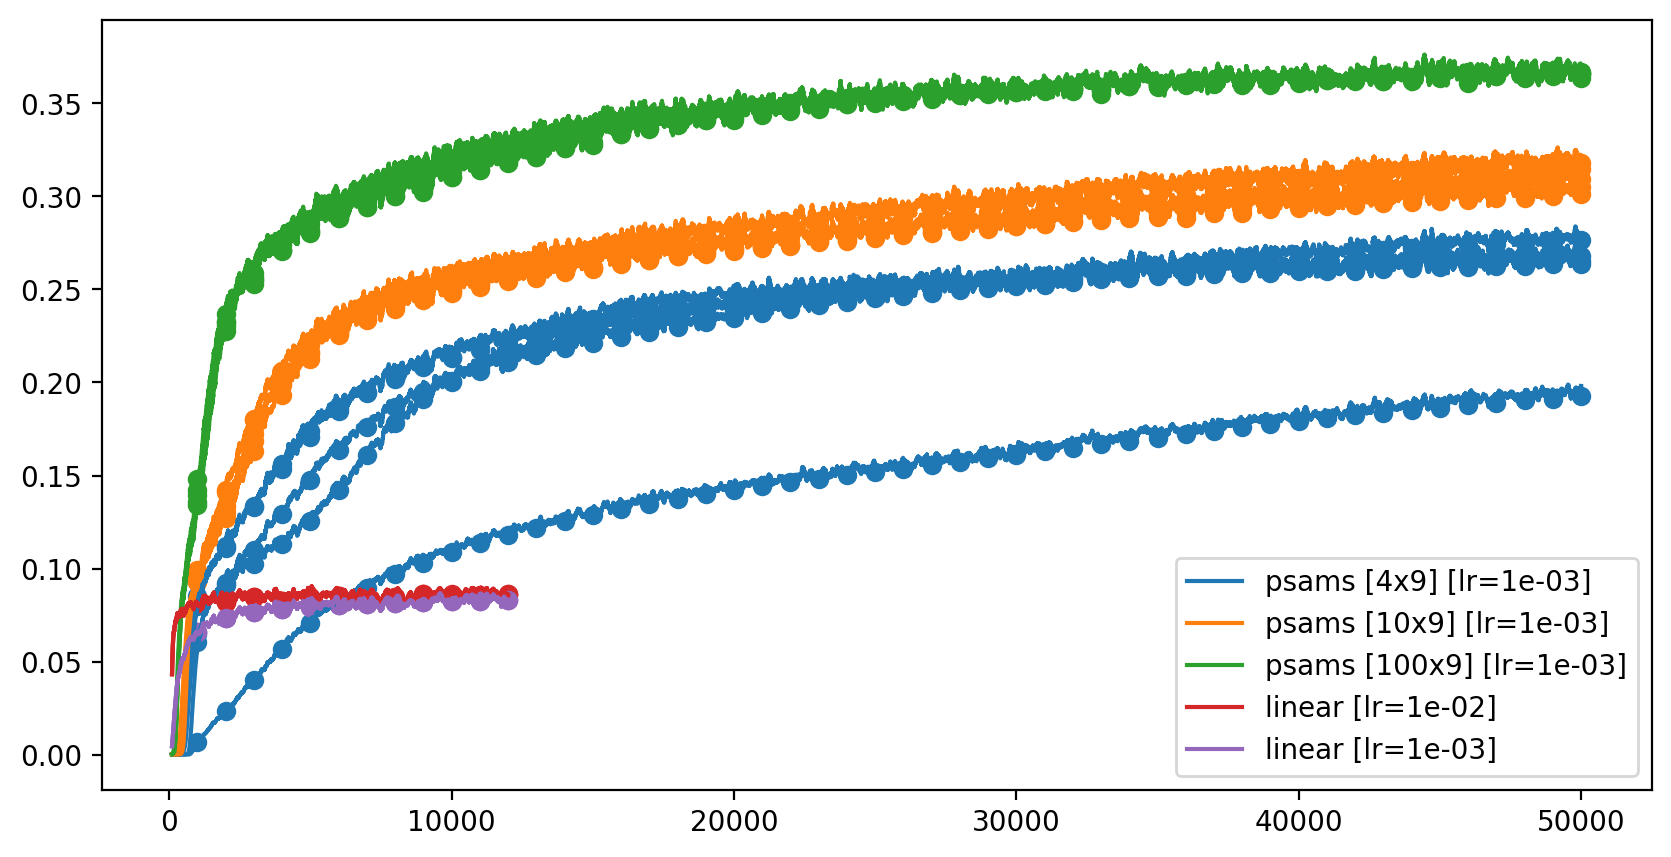

In [10]:
plt.figure(dpi=200, figsize=(10, 5))
baseline_res = plots_for_baseline()
plt.legend()
plt.show()

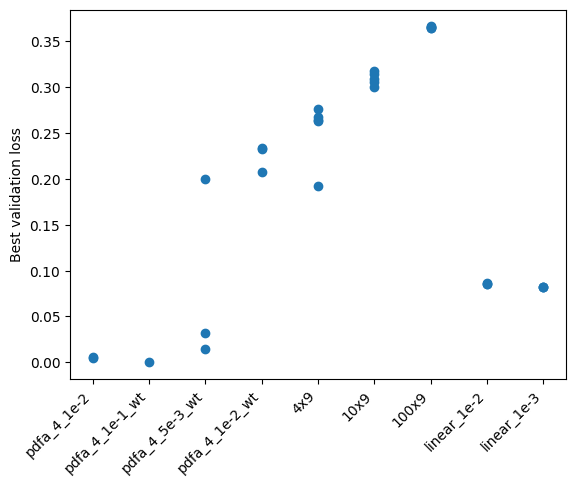

In [11]:
plot_best_validations_by_model({**pdfa_res, **baseline_res})

In [12]:
model = max(baseline_res["10x9"], key=lambda x: x[1])[0]

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
       <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
       <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>,
       <Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>],
      dtype=object)

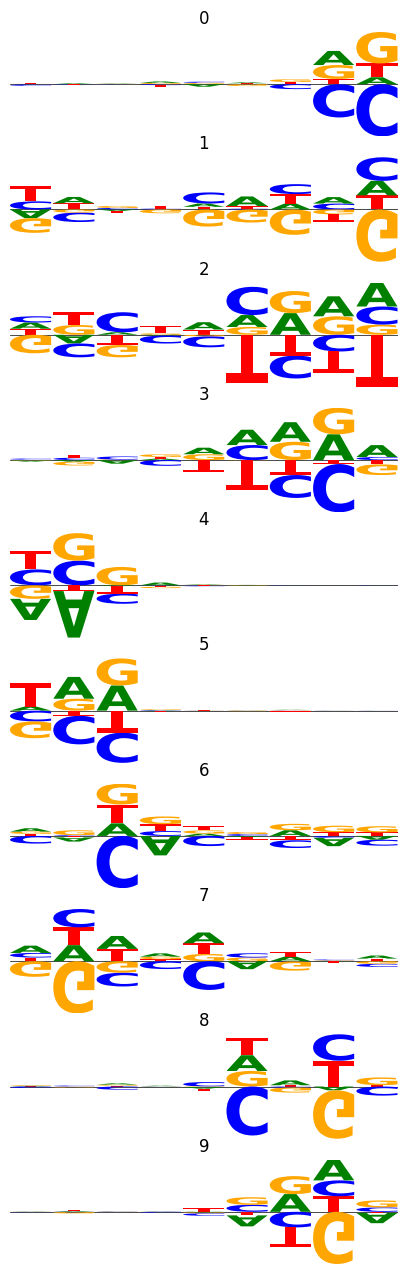

In [13]:
render_psams(
    model.psams.sequence_logos,
    names=range(len(model.psams.sequence_logos)),
    psam_mode="raw",
)

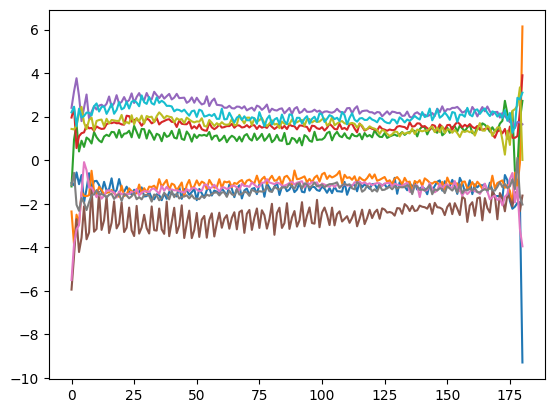

In [14]:
plt.plot(model.linear.weight_arr)
plt.show()

In [15]:
pdfa_model, _ = pdfa_res["pdfa_4_1e-2_wt"][0]
linpsam_4_1, _ = baseline_res["4x9"][0]
linpsam_10_1, _ = baseline_res["10x9"][0]
linpsam_100_1, _ = baseline_res["100x9"][0]
linpsam_100_2, _ = baseline_res["100x9"][1]

In [16]:
# train_model(0, 4, 1e-2, with_temperature=1, baselines=[linpsam_100_1])

In [18]:
from orthogonal_dfa.manual_dfa.stop_codon_dfa import (
    stop_codon_from_psams,
    stop_codon_psamdfa,
    ZeroProbability,
)

In [57]:
no_orf = stop_codon_psamdfa("TAG", "TAA", "TGA", zero_prob=ZeroProbability(1e-7)).cuda()
no_orf_ta = stop_codon_psamdfa("TAG", "TAA", zero_prob=ZeroProbability(1e-7)).cuda()

In [58]:
from orthogonal_dfa.oracle.evaluate import (
    conditional_mutual_information_from_log_confusion,
    evaluate_pdfas,
)

In [61]:
cmi = lambda test, *control: conditional_mutual_information_from_log_confusion(
    evaluate_pdfas(default_exon, test, control, oracle(), seed=0)
)[0]

In [62]:
cmi(pdfa_model.cuda(), linpsam_4_1.cuda())

np.float32(0.040839553)

2025-11-10 14:18:30.271569 Epoch 1, CMI: -0.0000
2025-11-10 14:18:35.523307 Epoch 2, CMI: -0.0000
2025-11-10 14:18:40.768249 Epoch 3, CMI: -0.0000
2025-11-10 14:18:46.019813 Epoch 4, CMI: 0.0000
2025-11-10 14:18:51.297120 Epoch 5, CMI: -0.0000
2025-11-10 14:18:56.558932 Epoch 6, CMI: 0.0000
2025-11-10 14:19:01.838469 Epoch 7, CMI: -0.0000
2025-11-10 14:19:07.091980 Epoch 8, CMI: -0.0000
2025-11-10 14:19:12.368498 Epoch 9, CMI: -0.0000
2025-11-10 14:19:24.024460 Epoch 10, CMI: -0.0000; Val CMI: 0.0000
2025-11-10 14:19:29.296978 Epoch 11, CMI: -0.0000
2025-11-10 14:19:34.571641 Epoch 12, CMI: 0.0000
2025-11-10 14:19:39.832789 Epoch 13, CMI: 0.0000
2025-11-10 14:19:45.111020 Epoch 14, CMI: -0.0000
2025-11-10 14:19:50.372333 Epoch 15, CMI: 0.0000
2025-11-10 14:19:55.635854 Epoch 16, CMI: -0.0000
2025-11-10 14:20:00.897690 Epoch 17, CMI: 0.0000
2025-11-10 14:20:06.167164 Epoch 18, CMI: 0.0000
2025-11-10 14:20:11.442716 Epoch 19, CMI: -0.0000
2025-11-10 14:20:23.115230 Epoch 20, CMI: 0.0000;

(PSAMPDFAWithTemperature(
   (psam_pdfa): PSAMPDFA(
     (psam): TorchPSAMs(
       (log_sigoid): LogSigmoid()
     )
     (pdfa): PDFA()
   )
 ),
 np.float32(2.7989316e-08))

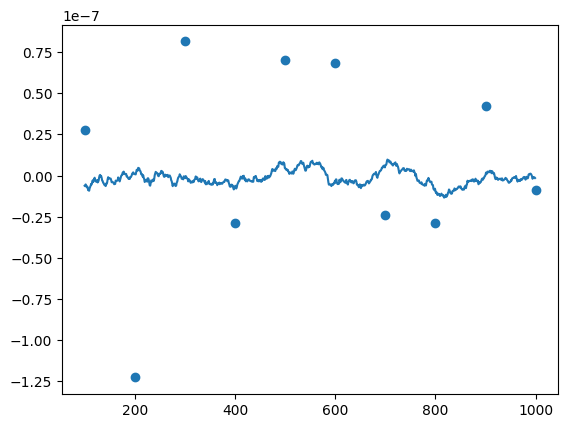

In [80]:
plot_curve(
    0, 4, 0.5e-3, with_temperature=1, baselines=[linpsam_100_1], batch_size=10_000
)

In [73]:
def wrt_each(m):
    result = [cmi(m.cuda())]
    for num_psams in 4, 10, 100:
        c, _ = baseline_res[f"{num_psams}x9"][0]
        result.append(cmi(m.cuda(), c.cuda(), c.cuda(), c.cuda()))
        # result.append(cmi(m.cuda(), c.cuda()))
    return result

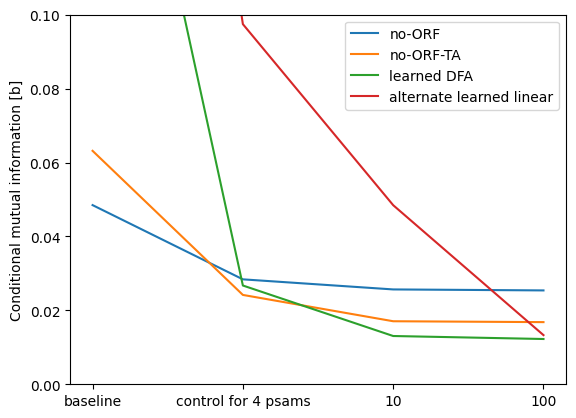

In [74]:
plt.plot(wrt_each(no_orf), label="no-ORF")
plt.plot(wrt_each(no_orf_ta), label="no-ORF-TA")
plt.plot(wrt_each(pdfa_model), label="learned DFA")
plt.plot(wrt_each(linpsam_100_2), label="alternate learned linear")
plt.xticks(range(4), ["baseline", "control for 4 psams", "10", "100"])
plt.legend()
plt.ylim(0, 0.1)
plt.ylabel("Conditional mutual information [b]")
plt.show()